# Dataset Preprocessing

In [16]:
import numpy as np
import pandas as pd
from rdkit import (Chem, RDLogger)
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

## Molecule, Descriptor, and Outlier Utility Functions

### `molecule_from_smiles(smiles)`
Converts a SMILES string into a cleaned **RDKit molecule object**, while temporarily silencing RDKit logs to avoid console spam.

**Process:**
1. Parse the SMILES into an RDKit molecule (`Chem.MolFromSmiles`).
2. Remove salts and keep the **largest fragment** using `LargestFragmentChooser`.
3. Re-sanitize the molecule to ensure validity.
4. Logging is muted during processing and restored afterward.

**Returns:**
- `(molecule, status)`  
  - `molecule`: RDKit molecule object or `None`  
  - `status`: `"succeed"`, `"failed"`, or `"error: <message>"`

---

### `calculate_descriptors(molecule)`
Calculates all available **1D and 2D molecular descriptors** using RDKit’s built-in descriptor list.

**Steps:**
1. Collect all descriptor names from `Descriptors._descList`.  
2. Use `MolecularDescriptorCalculator` to compute their values for the molecule.  
3. Return as a dictionary mapping *descriptor name → value*.

**Returns:**
- `dict`: `{ descriptor_name: value }`

---

### `outliers_iqr(df, factor=1.5)`
Applies the **Interquartile Range (IQR)** rule to cap extreme numeric values.

**Process:**
- Compute Q1 (25%) and Q3 (75%) for each column.  
- Define bounds: `[Q1 − 1.5×IQR, Q3 + 1.5×IQR]`.  
- Values beyond these limits are **clipped** to the nearest boundary.  
- Columns with zero IQR (flat values) are skipped.

**Purpose:**
Removes the influence of outliers **without deleting rows**, preserving dataset structure and stabilizing machine learning models.

In [17]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs (Only critical)
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def outliers_iqr(df, factor=1.5):
    df_copy = df.copy()
    for col in df_copy.columns:
        # Only for numeric columns, but clean_desc should already be numeric
        q1 = df_copy[col].quantile(0.25)
        q3 = df_copy[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat → skip
        if iqr == 0:
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr

        # Apply the IQR limits
        df_copy[col] = df_copy[col].clip(lower, upper)
    return df_copy

## Dataset Processing and Descriptor Cleaning Pipeline

This notebook processes the *in chemico* dataset by:
- Converting SMILES strings into RDKit molecule objects  
- Computing 1D/2D molecular descriptors  
- Cleaning and preparing descriptors for machine learning  

It produces two key outputs:
1. **Full Excel report** – original dataset + raw descriptors + molecule build status  
2. **Clean CSV files** – train/test feature matrices ready for ML modeling

---

### Configuration Variables

| Variable | Description |
|-----------|--------------|
| `ORIG_DATASET` | Path to the original Excel file with SMILES and labels |
| `SKIP_ROWS` | Number of rows to skip at the top of the Excel file (e.g. non-data header) |
| `SMILES_COL` | Column name containing SMILES strings |
| `TARGET_COL` | Column name of the target variable (e.g. `Phototoxicity`) |
| `FULL_OUTPUT_DATASET` | Excel output with all raw descriptors + molecule status |
| `TRAIN_X_CSV`, `TEST_X_CSV` | Clean numeric descriptor files for ML (train/test) |
| `TRAIN_Y_CSV`, `TEST_Y_CSV` | Corresponding label files for ML (train/test) |
| `SIMILARITY_THRESHOLD` | Drop descriptors where ≥ this fraction of values are identical (e.g. 0.80 = 80%) |

---

### Workflow Overview

#### 1 Load the Dataset
- Read the Excel file specified by `ORIG_DATASET` using `pandas.read_excel()`.
- Skip any non-data rows (`SKIP_ROWS`).

#### 2 Convert SMILES → RDKit Molecules
- Loop through the SMILES column (`SMILES_COL`).
- Convert each SMILES to an RDKit `Mol` object using `molecule_from_smiles()`.
- Track molecule build status (`"succeed"`, `"failed"`, or `"error: ..."`).

#### 3 Compute RDKit Descriptors
- For each valid molecule, compute 1D/2D descriptors with `calculate_descriptors()`.
- Store descriptor values as dictionaries in a list.

#### 4 Build the Descriptor Table
- Convert the list of descriptor dictionaries into a single `pandas.DataFrame`.
- Each **descriptor** becomes a **column**; each **molecule** becomes a **row**.

#### 5 Descriptor Cleaning (Leak-Free)
All cleaning is fitted **only on the training set** to prevent data leakage:
- Keep only **numeric** descriptor columns.
- Replace `inf` and `-inf` values with `NaN`.
- Fill missing values with the **median** from the **training set**.
- Drop **constant or near-constant** descriptors where ≥ `SIMILARITY_THRESHOLD` of values are identical.
- Apply **IQR-based clipping** (`outliers_iqr(df, factor=1.5)`) on the **training data only** to cap extreme outliers.

#### 6 Merge and Save Outputs
- Merge the **original dataset** and **raw descriptor data** into one DataFrame,  
  adding a `MoleculeStatus` column.
- Save:
  - The full annotated dataset → `FULL_OUTPUT_DATASET` (Excel)
  - Cleaned train/test features → `TRAIN_X_CSV` and `TEST_X_CSV`
  - Train/test labels → `TRAIN_Y_CSV` and `TEST_Y_CSV`

#### 7 Logging and Summary
After processing:
- Print the number of rows/columns for the full and clean datasets.
- List descriptors dropped as constant or almost constant.
- Show a preview (`head()`) of both full and cleaned feature sets.

---

### Notes
- Columns that are **completely NaN** are dropped *before splitting* (safe operation).
- Missing values, constant-column filtering, and IQR clipping are all **fit only on the training set**.
- This ensures a fully **data leakage–free** preprocessing pipeline, ready for ML experiments.

In [18]:
# Configuration
ORIG_DATASET = "in_chemico_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant treshold - tolerance
SIMILARITY_THRESHOLD = 0.80

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

# Build descriptors
descriptor_rows = []
state_molecules = []
molecules = []

# Loop over the SMILES column
for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    # If molecule construction failed - empty placeholder
    if molecule is None:
        descriptor_rows.append({})
        continue
    # Calculate descriptors for each molecule
    descriptor_rows.append(calculate_descriptors(molecule))

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
    axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

X_train = outliers_iqr(X_train, factor=1.5)

X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))
X_train.describe()

Full - Rows: 162/Columns: 230
                          Name                                                                                              IUPAC name CAS registry number    Structure  Phototoxicity                                                      SMILES code                            Sources               Note    Unnamed: 8 Unnamed: 9  Unnamed: 10 Unnamed: 11  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ    BertzCT      Chi0     Chi0n     Chi0v      Chi1    Chi1n    Chi1v    Chi2n    Chi2v    Chi3n    Chi3v    Chi4n    Chi4v  HallKierAlpha           Ipc    Kappa1   Kappa2   Kappa3  Labute

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_C_O_noCOO,fr_NH0,fr_NH1,fr_aniline,fr_benzene,fr_bicyclic,fr_ether,fr_halogen,fr_para_hydroxylation,fr_pyridine
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,...,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,11.352259,11.352259,0.193352,-0.913807,0.606684,14.198433,317.702837,300.605333,317.265179,115.248062,...,0.593023,1.263566,0.434109,0.500000,1.317829,0.604651,0.523256,0.670543,0.294574,0.232558
std,2.430989,2.430989,0.188957,1.107129,0.211797,4.792314,126.620808,122.168050,126.421616,43.814066,...,0.772495,1.444382,0.632393,0.728869,0.819532,0.797149,0.800050,0.913219,0.564622,0.476177
min,6.194108,6.194108,0.000297,-3.038324,0.139518,6.000000,46.069000,40.021000,46.041865,20.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.206402,10.206402,0.052299,-1.315329,0.481898,10.857143,232.239000,220.143000,232.084792,88.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.846296,11.846296,0.124071,-0.830880,0.652473,12.333333,313.788000,297.660000,313.098190,112.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.881264,12.881264,0.277145,-0.166667,0.791627,16.678571,381.379000,367.267000,381.075882,138.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,15.645307,15.645307,0.614414,1.311296,0.893230,25.410714,605.089000,587.953000,604.562518,213.000000,...,2.500000,5.000000,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000,2.000000,2.000000


https://chatgpt.com/g/g-p-68d661ef67388191b7290d6c68faf0b1-tp/c/690cbf43-8b1c-8325-85a0-331150e64038#:~:text=%D0%97%D0%B0%D0%B3%D1%80%D1%83%D0%B7%D0%BA%D0%B0%20%D0%B8%D1%81%D1%85%D0%BE%D0%B4%D0%BD%D0%BE%D0%B3%D0%BE%20%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%D0%B0

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Config
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"
FEATURE_IMPORT_CSV = "top_features_best.csv"

# Read X and y
X_train = pd.read_csv(TRAIN_X_CSV)
X_test = pd.read_csv(TEST_X_CSV)
y_train = pd.read_csv(TRAIN_Y_CSV).squeeze()
y_test = pd.read_csv(TEST_Y_CSV).squeeze()
#.squeeze() автоматически превращает DataFrame (162×1) → Series (162,). Ты читаешь CSV с помощью pandas.read_csv, и он создаёт DataFrame (2D объект), а не Series (1D). Просто “разверни” вектор в 1D


# Checks
assert list(X_train.columns) == list(X_test.columns), "Train/Test feature columns are misaligned."
assert len(X_train) == len(y_train) and len(X_test) == len(y_test), "X/y rows are misaligned."

model = RandomForestClassifier(
    n_estimators=134,          # Number of trees in the forest
    max_depth=None,            # Let trees grow until all leaves are pure or contain <min_samples_split
    min_samples_split=2,       # Minimum samples required to split a node
    min_samples_leaf=1,        # Minimum samples at a leaf node
    max_features="sqrt",       # √(n_features) used at each split (default for classification)
    bootstrap=True,            # Use bootstrap sampling (bagging)
    random_state=42,           # Reproducibility
    n_jobs=-1,                 # Use all available cores for speed
    class_weight="balanced"    # Handle slight class imbalance automatically
)


# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 score : {f1:.4f}")
print(f"ROC AUC  : {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))




Model performance:
Accuracy : 0.6364
Precision: 0.6875
Recall   : 0.6111
F1 score : 0.6471
ROC AUC  : 0.7463

Classification report:
              precision    recall  f1-score   support

           0      0.588     0.667     0.625        15
           1      0.688     0.611     0.647        18

    accuracy                          0.636        33
   macro avg      0.638     0.639     0.636        33
weighted avg      0.642     0.636     0.637        33




Top 10 features:
          feature  importance
        PEOE_VSA8    0.047586
MaxAbsEStateIndex    0.022898
       ExactMolWt    0.019135
            Chi2v    0.018477
            MolWt    0.016769
      EState_VSA5    0.016625
     BCUT2D_MWLOW    0.016433
   HeavyAtomMolWt    0.016130
   MaxEStateIndex    0.016081
            Chi0n    0.016065


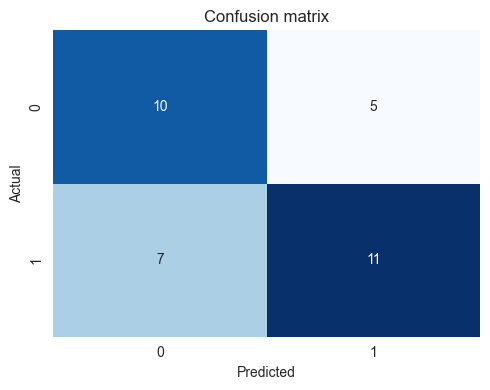

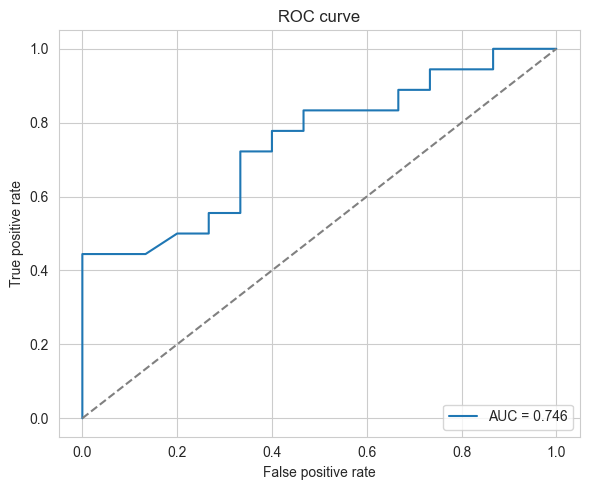

In [21]:
# Gain-based by default model.feature_importances_
feat_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)


# Most important first
feat_imp = feat_imp.sort_values("importance", ascending=False).reset_index(drop=True)

print("\nTop 10 features:")
print(feat_imp.head(10).to_string(index=False))

# Save ordered features
feat_imp.to_csv(FEATURE_IMPORT_CSV, index=False)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

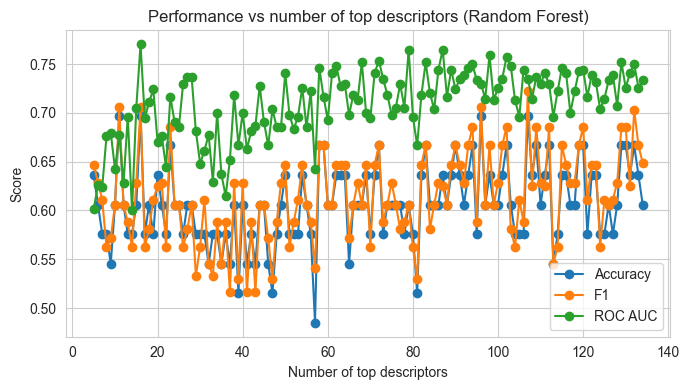


Best number of descriptors: 107
Top_N       107.000000
Accuracy      0.696970
F1            0.722222
ROC_AUC       0.735185
Name: 102, dtype: float64


In [23]:
results = []

# Sweep from 5 features up to all available
for n in range(5, len(feat_imp) + 1):
    top_feats = feat_imp["feature"].head(n).tolist()

    # Limit number of trees (no more than features)
    n_trees = min(n, len(top_feats))

    # Initialize Random Forest
    model = RandomForestClassifier(
        n_estimators=n_trees,     # <= number of descriptors
        random_state=42,
        n_jobs=-1,
        criterion="gini",
        max_depth=None,           # allow full depth
        max_features="sqrt",      # random subset of features per split
        class_weight="balanced"   # handle potential imbalance
    )

    # Train model
    model.fit(X_train[top_feats], y_train)

    # Predict on test set
    y_pred = model.predict(X_test[top_feats])
    y_prob = model.predict_proba(X_test[top_feats])[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((n, acc, f1, auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "Accuracy", "F1", "ROC_AUC"])

# Find best number of features (by F1 score)
best = res_df.iloc[res_df["F1"].idxmax()]
best_n = int(best.Top_N)

# Visualization
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["Accuracy"], label="Accuracy", marker="o")
plt.plot(res_df["Top_N"], res_df["F1"], label="F1", marker="o")
plt.plot(res_df["Top_N"], res_df["ROC_AUC"], label="ROC AUC", marker="o")
plt.xlabel("Number of top descriptors")
plt.ylabel("Score")
plt.title("Performance vs number of top descriptors (Random Forest)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"\nBest number of descriptors: {best_n}")
print(best)

In [ ]:
print(n_trees = min(n, len(top_feats)))

In [ ]:
## Feature Selection + Hyperparameter Optimization (Random Forest + Optuna)

# Imports
import optuna
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, \
    classification_report
from sklearn.model_selection import train_test_split

results = []
best_params_per_n = {}

# Sweep through increasing number of top descriptors
for n in range(5, len(feat_imp) + 1):
    top_feats = feat_imp["feature"].head(n).tolist()

    # Split (train/validation) inside training data
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train[top_feats], y_train, test_size=0.2, random_state=42, stratify=y_train
    )


    # Define Optuna objective
    def objective(trial):
        params = {
            # число дерев (не більше фіч)
            "n_estimators": "n_estimators": trial.suggest_int("n_estimators", 20, min(200, len(top_feats))),
            # максимальна глибина дерева
            "max_depth": trial.suggest_int("max_depth", 2, 15),
            # скільки фіч розглядати при кожному спліті
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            # мінімальна кількість прикладів у вузлі для поділу
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            # мінімальна кількість зразків у листі
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
            # збалансування класів
            "class_weight": trial.suggest_categorical("class_weight", ["balanced", None]),
            "random_state": 42,
            "n_jobs": -1
        }

        model = RandomForestClassifier(**params)
        model.fit(X_tr, y_tr)

        y_prob_val = model.predict_proba(X_val)[:, 1]
        auc_val = roc_auc_score(y_val, y_prob_val)
        return auc_val


    # Optuna study
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, show_progress_bar=False)

    best_val_auc = study.best_value
    results.append((n, best_val_auc))
    best_params_per_n[n] = study.best_trial.params

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "Val_ROC_AUC"])

# Pick best N by validation AUC
best_row = res_df.iloc[res_df["Val_ROC_AUC"].idxmax()]
best_n = int(best_row.Top_N)
best_val_auc = float(best_row.Val_ROC_AUC)

print(f"\nBest number of descriptors by validation AUC: {best_n} (Val ROC AUC = {best_val_auc:.4f})")

# Plot validation AUC curve
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["Val_ROC_AUC"], marker="o", label="Validation ROC AUC")
plt.xlabel("Number of top descriptors")
plt.ylabel("Validation ROC AUC")
plt.title("Validation AUC vs number of top descriptors (Random Forest)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# --- Final Training on best subset ---
selected_features = feat_imp["feature"].head(best_n).tolist()
X_train_sel = X_train[selected_features].copy()
X_test_sel = X_test[selected_features].copy()
best_params = best_params_per_n[best_n]

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_sel, y_train)

# Test evaluation
y_prob_test = final_model.predict_proba(X_test_sel)[:, 1]
y_pred_test = final_model.predict(X_test_sel)

acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test, zero_division=0)
rec = recall_score(y_test, y_pred_test, zero_division=0)
f1 = f1_score(y_test, y_pred_test, zero_division=0)
auc = roc_auc_score(y_test, y_prob_test)

print("\nFinal Random Forest model (selected by validation AUC):")
print(f"Top-N descriptors: {best_n}")
print("Best parameters:", best_params)
print(f"\nAccuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(f"ROC AUC: {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_test, digits=3))


[I 2025-11-07 16:59:20,163] A new study created in memory with name: no-name-85d65a88-3e85-45e4-bedd-458b30fa5ba3
[I 2025-11-07 16:59:20,270] Trial 0 finished with value: 0.6309523809523809 and parameters: {'n_estimators': 20, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 5, 'class_weight': None}. Best is trial 0 with value: 0.6309523809523809.
[I 2025-11-07 16:59:20,344] Trial 1 finished with value: 0.5714285714285715 and parameters: {'n_estimators': 8, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 5, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6309523809523809.
[I 2025-11-07 16:59:20,434] Trial 2 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 15, 'max_depth': 15, 'max_features': None, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight': None}. Best is trial 0 with value: 0.6309523809523809.
[I 2025-11-07 16:59:20,537] Trial 3 finished with value: 0.675595238